# XLM-ROBERTA Fine Tuning Pipeline
This notebook automates the fine tuning of NLP model XLM-ROBERTA


## Setup & Imports


In [26]:
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers.trainer_utils import get_last_checkpoint
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils import resample
from torch.nn import CrossEntropyLoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from tqdm import tqdm
from typing import List
from collections import Counter

## Configurations


In [2]:
DATA_PATHS = [
  "../../data/nlp/tweet_emotions.csv",
  "../../data/nlp/Sentiment-analysis-for-mental-health.csv"
]
MODEL_NAME = "xlm-roberta-base"

MODEL_PATH_FINETUNE_1 = "../../models/nlp/sentiment_finetune_1"
MODEL_PATH_MODEL_1 = "../../models/nlp/sentiment_model_1"

MODEL_PATH_FINETUNE_2 = "../../models/nlp/sentiment_finetune_2"
MODEL_PATH_MODEL_2 = "../../models/nlp/sentiment_model_2"


## Load Data

In [3]:
# Load two datasets
dataset_1_broad_emotion = load_dataset("csv", data_files=DATA_PATHS[0])
dataset_2_specialize = load_dataset("csv", data_files=DATA_PATHS[1])

# Define functions to rename datasets
def rename_data_columns(data: Dataset, column_names_to_change: List[str], new_column_names: List[str]) -> Dataset:
    if len(column_names_to_change) != len(new_column_names):
        raise ValueError("Both lists must have the same length.")
    
    dataset = data
    for old_name, new_name in zip(column_names_to_change, new_column_names):
        dataset = dataset.rename_column(old_name, new_name)

    print(dataset)
    
    return dataset

# Remove unwanted column
dataset_1_broad_emotion = dataset_1_broad_emotion.remove_columns(["tweet_id"])
dataset_2_specialize = dataset_2_specialize.remove_columns(["Unnamed: 0"])

# Rename
print("\nDataset: tweet_emotions")
dataset_1_broad_emotion = rename_data_columns(
    data=dataset_1_broad_emotion,
    column_names_to_change=['sentiment', 'content'],
    new_column_names=['labels', 'text']
  )

print("\nDataset: Sentiment-analysis-for-mental-health")
dataset_2_specialize = rename_data_columns(
    data=dataset_2_specialize,
    column_names_to_change=['status', 'statement'],
    new_column_names=['labels', 'text']
  )



Dataset: tweet_emotions
DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 40000
    })
})

Dataset: Sentiment-analysis-for-mental-health
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 53043
    })
})


## Data Pre-processing & Visualization


### Check unique labels



#### labels visualization


labels
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64
labels
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


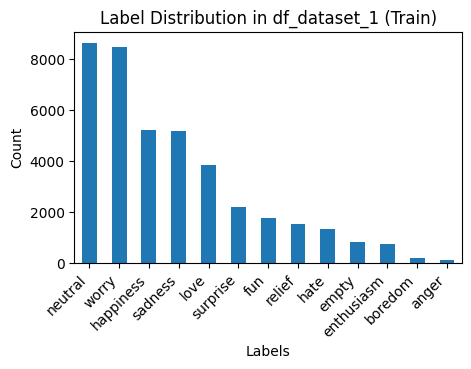

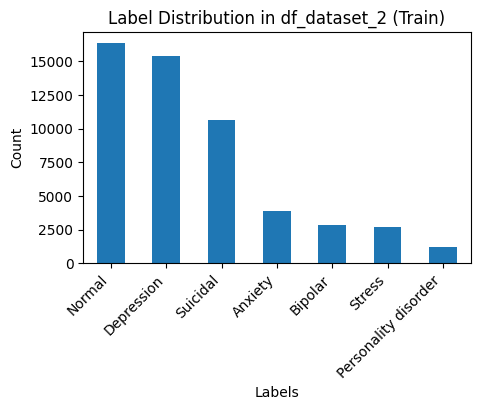

In [4]:
def label_visualization():
  # Convert data to pandas dataframe for visualization
  df_dataset_1 = dataset_1_broad_emotion["train"].to_pandas()
  df_dataset_2 = dataset_2_specialize["train"].to_pandas()

  # Count label frequencies
  label_for_df1_counts = df_dataset_1["labels"].value_counts()
  print(label_for_df1_counts)
  label_for_df2_counts = df_dataset_2["labels"].value_counts()
  print(label_for_df2_counts)


  # Plot distribution for df_dataset_1
  plt.figure(figsize=(5, 3))
  label_for_df1_counts.plot(kind="bar")
  plt.xticks(rotation=45, ha="right")
  plt.title("Label Distribution in df_dataset_1 (Train)")
  plt.xlabel("Labels")
  plt.ylabel("Count")
  plt.show()

  # Plot distribution for df_dataset_2
  plt.figure(figsize=(5, 3))
  label_for_df2_counts.plot(kind="bar")
  plt.xticks(rotation=45, ha="right")
  plt.title("Label Distribution in df_dataset_2 (Train)")
  plt.xlabel("Labels")
  plt.ylabel("Count")
  plt.show()

label_visualization()

### Remove special characters

In [5]:
def clean_text(example):
    text = example.get("text", "")

    if text is None or not isinstance(text, str) or text.strip() == "":
        return {"text": ""}   # keep it empty; will be dropped later

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove newlines and other non-word characters except spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return {"text": text}


dataset_1_broad_emotion = dataset_1_broad_emotion.map(clean_text)
dataset_2_specialize = dataset_2_specialize.map(clean_text)

df_1_peek = dataset_1_broad_emotion["train"].to_pandas()
df_2_peek = dataset_2_specialize["train"].to_pandas()

df_1_peek.head()

,labels,text
0,empty,tiffanylue i know i was listenin to bad habit ...
1,sadness,layin n bed with a headache ughhhhwaitin on yo...
2,sadness,funeral ceremonygloomy friday
3,enthusiasm,wants to hang out with friends soon
4,neutral,dannycastillo we want to trade with someone wh...


In [6]:
df_2_peek.head()

,text,labels
0,oh my gosh,Anxiety
1,trouble sleeping confused mind restless heart ...,Anxiety
2,all wrong back off dear forward doubt stay in ...,Anxiety
3,ive shifted my focus to something else but im ...,Anxiety
4,im restless and restless its been a month now ...,Anxiety


### Check for rows that has null or blank values

In [7]:
def check_for_null_blank(dataset, dataset_name="Dataset"):
    import pandas as pd

    # If it's a DatasetDict, loop over splits
    if hasattr(dataset, "keys"):  # DatasetDict
        for split in dataset.keys():
            print(f"Checking split: {split} in {dataset_name}\n")
            df = dataset[split].to_pandas()
            
            # Nulls
            print("Nulls in each column:")
            print(df[["text", "labels"]].isnull().sum())
            print("\n")
            
            # Rows with nulls
            print("Rows where text or labels are null/blank:")
            print(df[df["text"].isnull() | df["labels"].isnull()])
            print("\n")
            
            # Blank strings
            print("Check for blank and empty string values:")
            print("Blank texts:", (df["text"].str.strip() == "").sum())
            print("Blank labels:", (df["labels"].astype(str).str.strip() == "").sum())
            print("\n")
    else:  # Single Dataset
        df = dataset.to_pandas()
        print(f"Checking {dataset_name}\n")
        print("Nulls in each column:")
        print(df[["text", "labels"]].isnull().sum())
        print("\n")
        print("Rows where text or labels are null/blank:")
        print(df[df["text"].isnull() | df["labels"].isnull()])
        print("\n")
        print("Check for blank and empty string values:")
        print("Blank texts:", (df["text"].str.strip() == "").sum())
        print("Blank labels:", (df["labels"].astype(str).str.strip() == "").sum())
        print("\n")

check_for_null_blank(dataset_1_broad_emotion, "Dataset 1")
check_for_null_blank(dataset_2_specialize, "Dataset 2")


Checking split: train in Dataset 1

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [labels, text]
Index: []


Check for blank and empty string values:
Blank texts: 4
Blank labels: 0


Checking split: train in Dataset 2

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [text, labels]
Index: []


Check for blank and empty string values:
Blank texts: 369
Blank labels: 0




### Drop rows that has null / blank / empty string values

In [8]:
# Drop rows where statement or status is null
def drop_nulls_from_dataset(dataset, columns=["text", "labels"]):
    """
    Drops null and blank values from a Dataset or DatasetDict.
    Works for both cases.
    """
    if isinstance(dataset, DatasetDict):  # Case 1: DatasetDict with train/test
        cleaned_splits = {}
        for split_name, ds_split in dataset.items():
            df = ds_split.to_pandas()
            df = df.dropna(subset=columns)
            if "text" in columns:
                df = df[df["text"].str.strip() != ""]
            cleaned_splits[split_name] = Dataset.from_pandas(df)
            print(f"✅ Cleaned {split_name}: {len(ds_split)} → {len(df)} rows")
        return DatasetDict(cleaned_splits)

    elif isinstance(dataset, Dataset):  # Case 2: Single Dataset
        df = dataset.to_pandas()
        df = df.dropna(subset=columns)
        if "text" in columns:
            df = df[df["text"].str.strip() != ""]
        cleaned_dataset = Dataset.from_pandas(df)
        print(f"✅ Cleaned dataset: {len(dataset)} → {len(df)} rows")
        return cleaned_dataset

    else:
        raise TypeError("Expected Dataset or DatasetDict")

dataset_1_broad_emotion = drop_nulls_from_dataset(dataset_1_broad_emotion)
dataset_2_specialize = drop_nulls_from_dataset(dataset_2_specialize)

# Check counts again
check_for_null_blank(dataset_1_broad_emotion);
check_for_null_blank(dataset_2_specialize);

✅ Cleaned train: 40000 → 39996 rows
✅ Cleaned train: 53043 → 52674 rows
Checking split: train in Dataset

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [labels, text, __index_level_0__]
Index: []


Check for blank and empty string values:
Blank texts: 0
Blank labels: 0


Checking split: train in Dataset

Nulls in each column:
text      0
labels    0
dtype: int64


Rows where text or labels are null/blank:
Empty DataFrame
Columns: [text, labels, __index_level_0__]
Index: []


Check for blank and empty string values:
Blank texts: 0
Blank labels: 0




### Feature engineer Dataset 1

In [9]:
# Convert dataset 1 to a dataframe first
df_1 = dataset_1_broad_emotion["train"].to_pandas()

print("Original distribution:")
print(df_1['labels'].value_counts())

# Define mapping: fine -> grouped

label_mapping = {
    "happiness": "Positive",
    "fun": "Positive",
    "enthusiasm": "Positive",
    "relief": "Positive",
    "love": "Positive",
    
    "worry": "Anxiety",
    
    "sadness": "Sadness",
    "empty": "Sadness",
    "boredom": "Sadness",
    
    "anger": "Anger",
    "hate": "Anger",
    
    "surprise": "Surprise",
    "neutral": "Neutral"
}

# Apply mapping
df_1["grouped_label"] = df_1["labels"].map(label_mapping)

print("\nAfter grouping:")
print(df_1["grouped_label"].value_counts())

# Keep only the two columns we want
df_clean = df_1[["text", "grouped_label"]].rename(columns={"grouped_label": "labels"})

# Convert to HF Dataset
dataset_clean = Dataset.from_pandas(df_clean, preserve_index=False)

# Wrap in DatasetDict
dataset_1_broad_emotion = DatasetDict({
    "train": dataset_clean
})

# Remove unwanted column/feature
# Based on the graphs above i don't want "Neutral", "Surprise"
unwanted_labels_1 = ["Neutral", "Surprise"]
dataset_1_broad_emotion["train"] = dataset_1_broad_emotion["train"].filter(
    lambda example: example["labels"] not in unwanted_labels_1
)

print("\nFinal dataset size:", len(dataset_1_broad_emotion))
print(dataset_1_broad_emotion)



Original distribution:
labels
neutral       8635
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          826
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

After grouping:
grouped_label
Positive    13112
Neutral      8635
Anxiety      8459
Sadness      6170
Surprise     2187
Anger        1433
Name: count, dtype: int64


Filter:   0%|          | 0/39996 [00:00<?, ? examples/s]


Final dataset size: 1
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 29174
    })
})


### Feature engineerd Dataset 2


Filter:   0%|          | 0/52674 [00:00<?, ? examples/s]

labels
Positive    13112
Anxiety      8459
Sadness      6170
Anger        1433
Name: count, dtype: int64
labels
Normal        16339
Depression    15404
Suicidal      10649
Anxiety        3841
Stress         2587
Name: count, dtype: int64


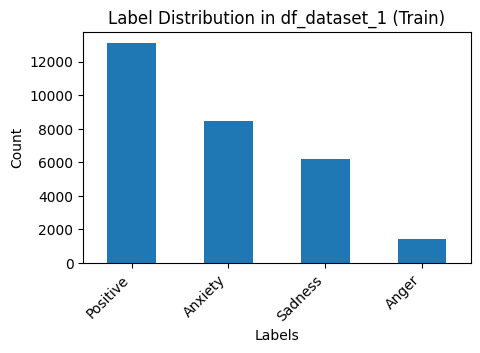

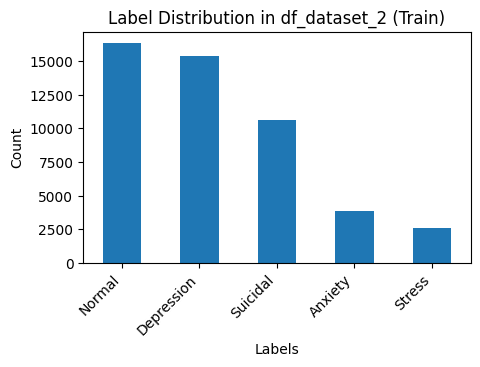

In [10]:
# Based on the graphs above i don't want "Bipolar", "Personality disorder"
unwanted_labels_2 = ["Bipolar", "Personality disorder"]
dataset_2_specialize["train"] = dataset_2_specialize["train"].filter(
    lambda example: example["labels"] not in unwanted_labels_2
)

label_visualization()

### Check the max length the text column contains

In [11]:
def get_min_max_len(example):
  lengths = example["train"].to_pandas()['text'].str.len()

  max_length = lengths.max()
  min_length = lengths.min()
  short_texts_count = (lengths <= min_length).sum()
  long_texts_count = (lengths >= max_length).sum()

  print(f"Max: {max_length}")
  print(f"Min: {min_length}")
  print(f'Short text count: {short_texts_count}')
  print(f'Long text count: {long_texts_count}')

print("Dataset 1")
get_min_max_len(dataset_1_broad_emotion)
print('\nDataset 2')
get_min_max_len(dataset_2_specialize)


Dataset 1
Max: 151
Min: 4
Short text count: 3
Long text count: 1

Dataset 2
Max: 31499
Min: 2
Short text count: 8
Long text count: 1


### Pre-process and encode label

Flattening the indices:   0%|          | 0/29174 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/48820 [00:00<?, ? examples/s]

Map:   0%|          | 0/29174 [00:00<?, ? examples/s]

Map:   0%|          | 0/48820 [00:00<?, ? examples/s]

labels
1    13112
2     8459
0     6170
3     1433
Name: count, dtype: int64
labels
1    16339
2    15404
3    10649
0     3841
4     2587
Name: count, dtype: int64


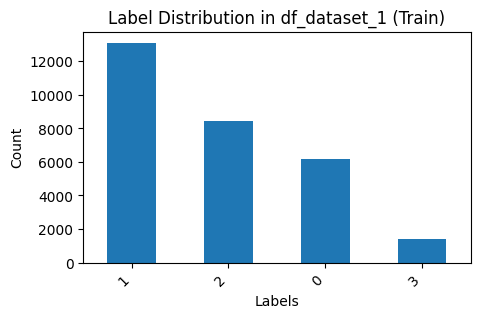

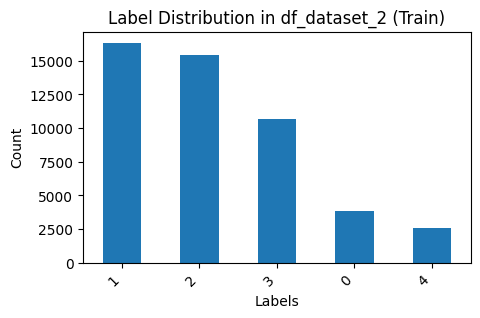

In [12]:
# Get unique labels
labels_1 = dataset_1_broad_emotion["train"].unique("labels")
label_1_to_id = {l: i for i, l in enumerate(labels_1)}
id_1_to_label = {i: l for l, i in label_1_to_id.items()}

labels_2 = dataset_2_specialize["train"].unique("labels")
label_2_to_id = {l: i for i, l in enumerate(labels_2)}
id_2_to_label = {i: l for l, i in label_2_to_id.items()}

def make_label_encoder(label_to_id: dict, column_name: str = "labels"):
    """Returns a function that encodes labels for the given column using label_to_id mapping."""
    def encode_labels(example):
        example[column_name] = label_to_id[example[column_name]]
        return example
    return encode_labels

encoder_for_data1 = make_label_encoder(label_1_to_id, column_name="labels")
encoder_for_data2 = make_label_encoder(label_2_to_id, column_name="labels")

dataset_1_broad_emotion = dataset_1_broad_emotion.map(encoder_for_data1)
dataset_2_specialize = dataset_2_specialize.map(encoder_for_data2)

# Re check if changes were applied correctly
label_visualization()

### Split training data to validation to test

In [13]:
def split_dataset_to_train_valid_test(dataset: DatasetDict, test_size: float = 0.2, val_size: float = 0.2, seed: int = 42) -> DatasetDict:
    """
    Splits a dataset into train, validation, and test sets.
    - First, takes a portion (test_size) from 'train' to make the test set.
    - Then, splits the remaining train into train/validation (val_size).
    """
    if "train" not in dataset:
        raise ValueError("DatasetDict must contain a 'train' split.")

    # Split into train + test
    data = dataset["train"].train_test_split(test_size=test_size, seed=seed)
    original_train = data["train"]
    original_test = data["test"]

    # Split original train further into train + validation
    train_valid_split = original_train.train_test_split(test_size=val_size, seed=seed)

    return DatasetDict({
        "train": train_valid_split["train"],
        "validation": train_valid_split["test"],
        "test": original_test
    })

dataset_1_broad_emotion = split_dataset_to_train_valid_test(dataset_1_broad_emotion)
dataset_2_specialize = split_dataset_to_train_valid_test(dataset_2_specialize)

print(dataset_1_broad_emotion)
print(dataset_2_specialize)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 18671
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 4668
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5835
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 31244
    })
    validation: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 7812
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 9764
    })
})


#### Over sample train data

In [ ]:
# train_labels = dataset_1_broad_emotion["train"]["labels"]
# print(Counter(train_labels))

# # Convert train split to Pandas
# df_1_train = pd.DataFrame(dataset_1_broad_emotion["train"])

# # Count classes
# class_counts = df_1_train["labels"].value_counts()
# max_count = class_counts.max()

# # Oversample each class
# df_list = []
# for label, count in class_counts.items():
#     df_label = df_1_train[df_1_train["labels"] == label]
#     df_upsampled = df_label.sample(max_count, replace=True, random_state=42)
#     df_list.append(df_upsampled)

# # Concatenate back
# df_1_train_balanced = pd.concat(df_list).sample(frac=1, random_state=42).reset_index(drop=True)

# # Convert back to HuggingFace Dataset
# balanced_train_dataset_1 = Dataset.from_pandas(df_1_train_balanced)

# dataset_1_broad_emotion = DatasetDict({
#     "train": balanced_train_dataset_1,
#     "validation": dataset_1_broad_emotion["validation"],
#     "test": dataset_1_broad_emotion["test"]
# })

# print(dataset_1_broad_emotion)

## Model Training / Fine Tuning


### Define model training functions

#### Load Tokenizer + Model

In [14]:
def load_model_and_tokenizer(model_name: str, labels: list[str], id2label: dict[int, str], label2id: dict[str, int]):
    """
    Loads a tokenizer and model for sequence classification.

    Args:
        model_name (str): Hugging Face model name or path.
        labels (list[str]): List of labels for classification.
        id2label (dict[int, str]): Mapping from ID to label name.
        label2id (dict[str, int]): Mapping from label name to ID.

    Returns:
        tokenizer, model
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id
    )
    return tokenizer, model

def tokenize_dataset(dataset: Dataset, tokenizer: PreTrainedTokenizerBase, max_length: int = 256, num_proc: int = 4):
    return dataset.map(
        lambda examples: tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length,
        ),
        batched=True,
        num_proc=num_proc
    )



#### Check max length to use

In [15]:
def plot_token_length_distribution(dataset, text_column='text', dataset_name="Dataset"):
    """
    Plots the distribution of sentence lengths or token lengths.
    
    Args:
        dataset: Hugging Face Dataset (tokenized or raw).
        text_column: Name of the column to measure length on. 
                     Use 'text' for raw strings or 'input_ids' for tokenized lists.
        dataset_name: Optional name for labeling the plot.
    """
    # Check first row type to decide how to measure length
    first_elem = dataset[0][text_column]
    
    if isinstance(first_elem, list):  # tokenized
        lengths = [len(x) for x in dataset[text_column]]
        unit = "tokens"
    elif isinstance(first_elem, str):  # raw text
        lengths = [len(x.split()) for x in dataset[text_column]]  # measure words
        unit = "words"
    else:
        raise ValueError(f"Column {text_column} has unsupported type: {type(first_elem)}")
    
    print(f"{dataset_name} {unit} stats:")
    print('Max length:', max(lengths))
    print('Min length:', min(lengths))
    
    plt.figure(figsize=(5, 2))
    plt.hist(lengths, bins=50, rwidth=0.9)
    plt.xlabel(f'Sequence Length ({unit})', fontsize=6)
    plt.ylabel('# of Samples', fontsize=6)
    plt.title(f'{unit.capitalize()} Length Distribution for {dataset_name}', fontsize=10)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.show()

#### Compute Class Weight


In [16]:
def compute_class_weights(dataset, label_column="labels", device="cpu"):
    """
    Compute normalized class weights from a dataset.

    Args:
        dataset: Hugging Face Dataset split (e.g. dataset["train"])
        label_column: name of the label column
        device: "cpu" or "cuda"

    Returns:
        torch.tensor of class weights
    """
    labels = np.array(dataset[label_column])
    class_counts = np.bincount(labels)

    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_counts)

    return torch.tensor(class_weights, dtype=torch.float).to(device)

### Define reusable classes

#### Focal Loss

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

#### Weighted Trainer

In [18]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = labels.to(logits.device)

        # Use CrossEntropyLoss with class weights
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device) if self.class_weights is not None else None)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

### Train on Dataset (1)

#### Load tokenizer and tokenize data

In [19]:
# Load tokenizer and model
tokenizer_1, model_1 = load_model_and_tokenizer(
    model_name= MODEL_NAME,
    labels= labels_1,
    id2label=id_1_to_label,
    label2id=id_1_to_label
)

# Tokenize dataset
dataset_1_broad_emotion = tokenize_dataset(
    dataset=dataset_1_broad_emotion,
    tokenizer=tokenizer_1,
    max_length=256,
    num_proc=1
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/18671 [00:00<?, ? examples/s]

Map:   0%|          | 0/4668 [00:00<?, ? examples/s]

Map:   0%|          | 0/5835 [00:00<?, ? examples/s]

#### Train Model from our first dataset

In [20]:
# Set format for PyTorch
dataset_1_broad_emotion.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

# Compute class weight
class_weights_1 = compute_class_weights(dataset_1_broad_emotion["train"], label_column="labels", device="cuda")

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    acc = accuracy.compute(predictions=preds, references=p.label_ids)
    f1_score = f1.compute(predictions=preds, references=p.label_ids, average="macro")
    
    return {**acc, **f1_score}

training_args = TrainingArguments(
    output_dir=MODEL_PATH_FINETUNE_1,

    # Evaluation & saving
    eval_strategy="steps",             # evaluate more frequently
    eval_steps=500,                    # evaluate every 500 steps
    save_strategy="steps",             # save every eval
    save_steps=500,
    save_total_limit=3,                # keep last 3 checkpoints

    # Optimizer
    learning_rate=2e-5,
    warmup_ratio=0.1,                  # 10% warmup               
    weight_decay=0.05,                 # helps reduce overfitting

    # Batch size
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,     # effective batch size 16

    # Mixed precision
    fp16=True,                         # faster training

    # Training length
    num_train_epochs=5,                # shorter to prevent overfitting
    load_best_model_at_end=True,       # load checkpoint with best validation loss
    metric_for_best_model="f1",  # choose metric to track best model

    # Misc
    dataloader_num_workers=4,
    # logging_steps=100,                 # logs every 100 steps
    # logging_dir=f"{MODEL_PATH_FINETUNE_1}/logs"
)

trainer = Trainer(
    model=model_1,
    args=training_args,
    train_dataset=dataset_1_broad_emotion["train"],
    eval_dataset=dataset_1_broad_emotion["validation"],  # <-- use validation here
    tokenizer=tokenizer_1,
    compute_metrics=compute_metrics,
)

last_checkpoint = get_last_checkpoint(MODEL_PATH_FINETUNE_1)

trainer.train(resume_from_checkpoint=last_checkpoint)

C:\Users\PC\AppData\Local\Temp\ipykernel_2720\547669839.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
500,1.173900,0.976532,0.581620,0.327341
1000,0.999300,0.948569,0.601971,0.391213
1500,0.947500,0.943873,0.595973,0.432314
2000,0.926900,0.947065,0.599614,0.485828
2500,0.871800,0.924963,0.621894,0.509383
3000,0.825900,0.920582,0.619537,0.506657
3500,0.835100,0.922539,0.611825,0.513490
4000,0.750500,0.972919,0.606898,0.508385
4500,0.736900,0.979380,0.617181,0.516779
5000,0.693000,1.022871,0.617395,0.519307


TrainOutput(global_step=5835, training_loss=0.8467015937341005, metrics={'train_runtime': 2059.5484, 'train_samples_per_second': 45.328, 'train_steps_per_second': 2.833, 'total_flos': 1.228158682543104e+16, 'train_loss': 0.8467015937341005, 'epoch': 5.0})

#### Save Checkpoint

In [21]:
model_1.save_pretrained(MODEL_PATH_MODEL_1)
tokenizer_1.save_pretrained(MODEL_PATH_MODEL_1)

('../../models/nlp/sentiment_model_1\\tokenizer_config.json',
 '../../models/nlp/sentiment_model_1\\special_tokens_map.json',
 '../../models/nlp/sentiment_model_1\\tokenizer.json')

#### Load the trained model and then test in the test dataset

In [22]:
model_test_1 = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH_MODEL_1)
tokenizer_test_1 = AutoTokenizer.from_pretrained(MODEL_PATH_MODEL_1)

#### Make Predictions 

In [23]:
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

model_test_1.to("cuda") # Ensure that model is loaded in the GPU
model_test_1.eval()

# Torch DataLoader for test set
test_loader = DataLoader(dataset_1_broad_emotion["test"], batch_size=32)  # increase batch size if possible

all_preds_1 = []
all_labels_1 = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
        # Move to GPU if available
        batch = {k: v.to(model_test_1.device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}

        outputs = model_test_1(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds_1.extend(preds.cpu().numpy())
        all_labels_1.extend(batch["labels"].cpu().numpy())


CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3060


Evaluating: 100%|██████████| 183/183 [00:42<00:00,  4.29batch/s]


#### Compute Accuracy / F1

In [24]:
acc_1 = accuracy_score(all_labels_1, all_preds_1)
f1_1 = f1_score(all_labels_1, all_preds_1, average="macro")

print(f"Train set accuracy: {acc_1:.4f}")
print(f"Train set F1: {f1_1:.4f}")

Train set accuracy: 0.6144
Train set F1: 0.5121


In [27]:
def compute_baselines(hf_dataset_split, label_names=None, n_sim=1000, seed=42):
    """
    hf_dataset_split: a HuggingFace Dataset split (e.g. dataset['train'])
    label_names: optional list of label names in index order (for pretty printing)
    n_sim: number of simulations for random(prior) baseline estimation
    """
    rng = np.random.default_rng(seed)
    labels = np.array(hf_dataset_split["labels"])
    n = len(labels)
    counts = Counter(labels)
    num_labels = len(counts)
    # class prior distribution from data
    class_priors = np.array([counts.get(i, 0) for i in range(max(counts.keys())+1)], dtype=float)
    class_priors = class_priors / class_priors.sum()

    print("Total examples:", n)
    print("Class counts:", counts)
    if label_names:
        for i, name in enumerate(label_names):
            print(f"  {i}: {name} -> {counts.get(i,0)}")

    # 1) majority class baseline
    majority_label = max(counts.items(), key=lambda x: x[1])[0]
    majority_preds = np.full_like(labels, fill_value=majority_label)
    maj_acc = accuracy_score(labels, majority_preds)
    maj_macro_f1 = f1_score(labels, majority_preds, average="macro")
    print(f"\nMajority baseline: predict class {majority_label} (count={counts[majority_label]})")
    print(f"  Accuracy = {maj_acc:.4f}")
    print(f"  Macro-F1 = {maj_macro_f1:.4f}")

    # 2) expected random(prior) baseline — analytic expected accuracy = sum(p_i * p_i)
    expected_acc_analytic = np.sum(class_priors * class_priors)
    print(f"\nRandom(prior) analytic expected accuracy = sum(p_i^2) = {expected_acc_analytic:.4f}")

    # 3) simulate random(prior) baseline to get expected macro-f1 too
    sim_accs = []
    sim_macro_f1s = []
    for _ in range(n_sim):
        sim_preds = rng.choice(len(class_priors), size=n, p=class_priors)
        sim_accs.append(accuracy_score(labels, sim_preds))
        sim_macro_f1s.append(f1_score(labels, sim_preds, average="macro"))
    print(f"Random(prior) simulated (n={n_sim}):")
    print(f"  Accuracy mean = {np.mean(sim_accs):.4f} (std {np.std(sim_accs):.4f})")
    print(f"  Macro-F1 mean = {np.mean(sim_macro_f1s):.4f} (std {np.std(sim_macro_f1s):.4f})")

    # 4) show trivial classification report for majority baseline
    print("\nClassification report for majority baseline (per-class):")
    print(classification_report(labels, majority_preds, zero_division=0, target_names=label_names))

    return {
        "counts": counts,
        "class_priors": class_priors,
        "majority_label": majority_label,
        "majority_acc": maj_acc,
        "majority_macro_f1": maj_macro_f1,
        "random_prior_acc_mean": np.mean(sim_accs),
        "random_prior_macro_f1_mean": np.mean(sim_macro_f1s),
    }

# Example usage (adjust variable names if needed):
# If you have label names, pass them as label_names list.
# For your grouped Dataset 1 example:
# label_names = ["Positive","Anxiety","Sadness","Anger"]  # or whatever mapping you used
baselines = compute_baselines(dataset_1_broad_emotion["train"], label_names=None, n_sim=2000)

Total examples: 18671
Class counts: Counter({np.int64(1): 8385, np.int64(2): 5401, np.int64(0): 3950, np.int64(3): 935})

Majority baseline: predict class 1 (count=8385)
  Accuracy = 0.4491
  Macro-F1 = 0.1550

Random(prior) analytic expected accuracy = sum(p_i^2) = 0.3326
Random(prior) simulated (n=2000):
  Accuracy mean = 0.3326 (std 0.0032)
  Macro-F1 mean = 0.2499 (std 0.0031)

Classification report for majority baseline (per-class):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3950
           1       0.45      1.00      0.62      8385
           2       0.00      0.00      0.00      5401
           3       0.00      0.00      0.00       935

    accuracy                           0.45     18671
   macro avg       0.11      0.25      0.15     18671
weighted avg       0.20      0.45      0.28     18671



### Train on Dataset (2)

#### Load tokenizer and tokenize data

In [30]:
# Load tokenizer and model
model_2 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH_MODEL_1,
    num_labels=len(labels_2),          # dataset 2 label count
    id2label=id_2_to_label,            # dataset 2 id->label mapping
    label2id=label_2_to_id,             # dataset 2 label->id mapping
    ignore_mismatched_sizes = True
)
tokenizer_2 = AutoTokenizer.from_pretrained(MODEL_PATH_MODEL_1)

# Tokenize dataset
dataset_2_specialize = tokenize_dataset(
    dataset=dataset_2_specialize,
    tokenizer=tokenizer_2,
    max_length=512,
    num_proc=4
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at ../../models/nlp/sentiment_model_1 and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map (num_proc=4):   0%|          | 0/31244 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7812 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/9764 [00:00<?, ? examples/s]

In [31]:

# Set format for PyTorch
dataset_2_specialize.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    acc = accuracy.compute(predictions=preds, references=p.label_ids)
    f1_score = f1.compute(predictions=preds, references=p.label_ids, average="macro")
    
    return {**acc, **f1_score}

training_args = TrainingArguments(
    output_dir=MODEL_PATH_FINETUNE_2,

    # Evaluation & saving
    eval_strategy="steps",             # evaluate more frequently
    eval_steps=500,                    # evaluate every 500 steps
    save_strategy="steps",             # save every eval
    save_steps=500,
    save_total_limit=3,                # keep last 3 checkpoints

    # Optimizer
    learning_rate=2e-5,
    warmup_ratio=0.1,                  # 10% warmup               
    weight_decay=0.05,                 # helps reduce overfitting

    # Batch size
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,     # effective batch size 16

    # Mixed precision
    fp16=True,                         # faster training

    # Training length
    num_train_epochs=5,                # shorter to prevent overfitting
    load_best_model_at_end=True,       # load checkpoint with best validation loss
    metric_for_best_model="f1",  # choose metric to track best model

    # Misc
    dataloader_num_workers=4,
    # logging_steps=100,                 # logs every 100 steps
    # logging_dir=f"{MODEL_PATH_FINETUNE_1}/logs"
)

trainer = Trainer(
    model=model_2,
    args=training_args,
    train_dataset=dataset_2_specialize["train"],
    eval_dataset=dataset_2_specialize["validation"],  # <-- use validation here
    tokenizer=tokenizer_2,
    compute_metrics=compute_metrics,
)

last_checkpoint = get_last_checkpoint(MODEL_PATH_FINETUNE_2)

trainer.train(resume_from_checkpoint=last_checkpoint)

C:\Users\PC\AppData\Local\Temp\ipykernel_2720\278062464.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
500,1.170100,0.763364,0.710958,0.557899
1000,0.677700,0.585196,0.761905,0.725457
1500,0.558700,0.531827,0.789171,0.739893
2000,0.503600,0.511509,0.793779,0.772450
2500,0.449900,0.518751,0.791987,0.761725
3000,0.452100,0.503697,0.796979,0.784416
3500,0.439900,0.468878,0.817716,0.790335
4000,0.406500,0.462980,0.819124,0.795284
4500,0.365800,0.467425,0.817332,0.806166
5000,0.354500,0.503608,0.818100,0.778629


TrainOutput(global_step=9765, training_loss=0.40617538155254435, metrics={'train_runtime': 5807.9693, 'train_samples_per_second': 26.898, 'train_steps_per_second': 1.681, 'total_flos': 4.110431621572608e+16, 'train_loss': 0.40617538155254435, 'epoch': 5.0})

#### Save Checkpoint

In [32]:
model_2.save_pretrained(MODEL_PATH_MODEL_2)
tokenizer_2.save_pretrained(MODEL_PATH_MODEL_2)

('../../models/nlp/sentiment_model_2\\tokenizer_config.json',
 '../../models/nlp/sentiment_model_2\\special_tokens_map.json',
 '../../models/nlp/sentiment_model_2\\tokenizer.json')

#### Load trained model and then test it in the test dataset

In [33]:
model_test_2 = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH_MODEL_2)
tokenizer_test_2 = AutoTokenizer.from_pretrained(MODEL_PATH_MODEL_2)

#### Make predictions

In [34]:

print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

model_test_2.to("cuda") # Ensure that model is loaded in the GPU
model_test_2.eval()

# Torch DataLoader for test set
test_loader = DataLoader(dataset_2_specialize["test"], batch_size=32)  # increase batch size if possible

all_preds_2 = []
all_labels_2 = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
        # Move to GPU if available
        batch = {k: v.to(model_test_2.device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}

        outputs = model_test_2(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds_2.extend(preds.cpu().numpy())
        all_labels_2.extend(batch["labels"].cpu().numpy())


CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3060


Evaluating: 100%|██████████| 306/306 [02:49<00:00,  1.80batch/s]


#### Compute Accuracy / F1

In [35]:
acc_2 = accuracy_score(all_labels_2, all_preds_2)
f1_2 = f1_score(all_labels_2, all_preds_2, average="macro")

print(f"Train set accuracy: {acc_2:.4f}")
print(f"Train set F1: {f1_2:.4f}")

Train set accuracy: 0.8305
Train set F1: 0.8161


In [36]:
baselines_2 = compute_baselines(dataset_2_specialize["train"], label_names=None, n_sim=2000)

Total examples: 31244
Class counts: Counter({np.int64(1): 10550, np.int64(2): 9765, np.int64(3): 6797, np.int64(0): 2445, np.int64(4): 1687})

Majority baseline: predict class 1 (count=10550)
  Accuracy = 0.3377
  Macro-F1 = 0.1010

Random(prior) analytic expected accuracy = sum(p_i^2) = 0.2681
Random(prior) simulated (n=2000):
  Accuracy mean = 0.2681 (std 0.0024)
  Macro-F1 mean = 0.2001 (std 0.0022)

Classification report for majority baseline (per-class):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2445
           1       0.34      1.00      0.50     10550
           2       0.00      0.00      0.00      9765
           3       0.00      0.00      0.00      6797
           4       0.00      0.00      0.00      1687

    accuracy                           0.34     31244
   macro avg       0.07      0.20      0.10     31244
weighted avg       0.11      0.34      0.17     31244

